# Training of a Hedgie Tracker: An Exploration of Training Techniques to Avoid Overfitting

Segmentation is the process of seperating an object of interest from the background. It is a common first step in computer vision tasks such as identifying signs and pedestrians for self-driving cars or tracking tumour size in medical MRI. Segmentation is also a fundamentally challenging problem as it is not clearly defined mathematically and therefore segmentation algorithms are often empirical with parameters that must be tuned to specifiy the object of interest. This empirical nature make segmentation a natural fit for deep learning, which takes in images with user defined labels specifying explicitly the object(s) of interest.

There has been much work exploring how different deep learning architectures are currently being used for improved image segmentation, many of these are surveyed in this review: [Medical Image Segmentation Using Deep Learning:
A Survey](https://arxiv.org/pdf/2009.13120.pdf). In this tutorial, we look at one narrow aspect of contemporary deep learning practices, which is training strategies, in particular how to avoid overfitting. Traditionally, the best way to avoid overfitting is to simply add more data to train on. But due to the high cost of quality annotated data, that is in

In [1]:
from fastai.vision.all import *

base_path = Path('.').absolute().parent.parent
path = base_path / 'data' / 'train'
test_path = path.parent/'test'
fnames = get_image_files(path/'images')
print('example file name:', fnames[0])
print('of', len(fnames), 'training examples')

example file name: D:\Dev\hedgehog_finder\data\train\images\1\1.png
of 301 training examples


## Define DataLoaders

## Baseline model, no image augmentation

In [2]:
from hedgiefinder.dataloading import get_msk

codes = ['Background', 'Hog', 'Outline']

def get_dls_no_aug(bs=10, size=224):
    hogvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                       get_items=get_image_files,
                       splitter=RandomSplitter(),
                       get_y=get_msk,
                       item_tfms=Resize(size, method='squish'))

    return hogvid.dataloaders(path / 'images', path=path, bs=bs)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


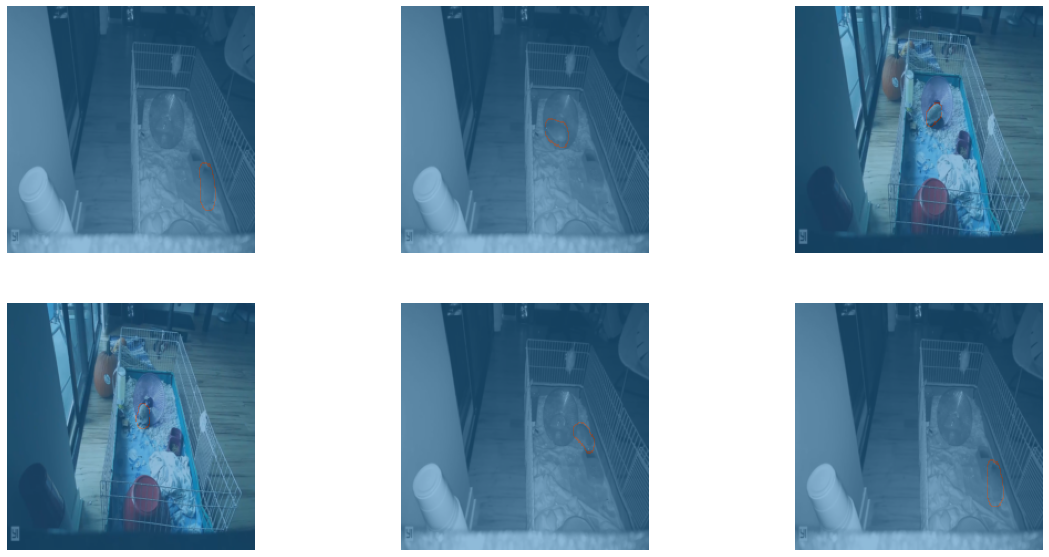

In [3]:
dls = get_dls_no_aug()
dls.show_batch(max_n=6, figsize=(20,10))

Note: When using CSVLogger, it will not pickle so the model cannot be saved, rather you need to use a partial like shown below per [this recommendation](https://forums.fast.ai/t/export-learner-for-multi-label-classification-fails/47816/2?u=bnel1201):

In [4]:
def load_model(dls, model_name, append=False):
    CSV_callback=partial(CSVLogger, fname=f'{model_name}_history', append=append)
    return unet_learner(dls, resnet34, cbs=[ShowGraphCallback(), CSV_callback()], metrics=[foreground_acc])

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,foreground_acc,time
0,0.214036,0.038967,0.000000,00:34


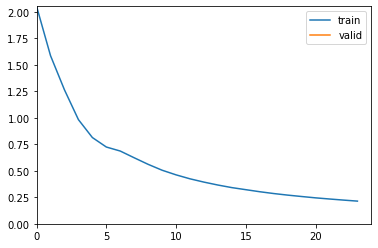

epoch,train_loss,valid_loss,foreground_acc,time
0,0.031316,0.048892,0.000000,00:28
1,0.026015,0.036263,0.002358,00:28
2,0.021540,0.043651,0.038717,00:28
3,0.017222,0.051214,0.033345,00:30
4,0.014162,0.083263,0.044440,00:30
5,0.012006,0.111397,0.027029,00:28
6,0.010756,0.052413,0.136708,00:29
7,0.009612,0.088157,0.070822,00:28
8,0.008516,0.059248,0.162803,00:28
9,0.007799,0.033808,0.262219,00:29


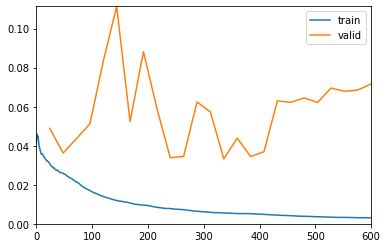

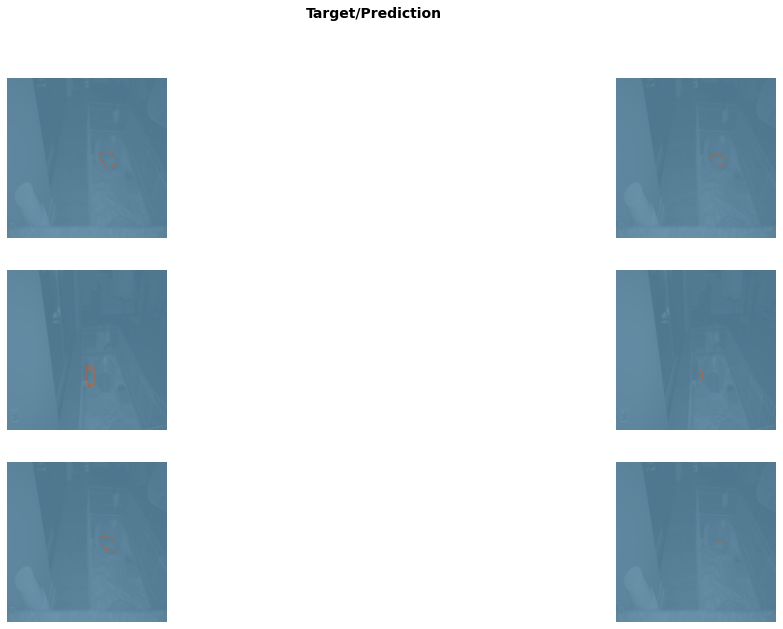

In [5]:
no_aug_learner = load_model(get_dls_no_aug(), 'no_aug')
no_aug_learner.fine_tune(25)
no_aug_learner.show_results(max_n=3, figsize=(20,10))

Terrible! Without any augmentation the model doesn't generalize at all. We simply don't have enough training data. What are we to do? Data augmentation is a major theme of weakly-supervised learning, and a major focus of fastai, whose goal is to democratize deep learning and one way to do that is to lower the requirement of massive amounts of training data that most of us don't have access to.

In [6]:
def get_dls_no_norm(bs=10, size=224):
    hogvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                       get_items=get_image_files,
                       splitter=RandomSplitter(),
                       get_y=get_msk,
                       batch_tfms=[*aug_transforms(do_flip=False, max_rotate=2)],
                       item_tfms=Resize(size, method='squish'))

    return hogvid.dataloaders(path / 'images', path=path, bs=bs)

## Baseline with basic augmentations but without normalization

Show sample augmentations like in Fastbook

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,foreground_acc,time
0,0.127280,0.033817,0.000000,00:30


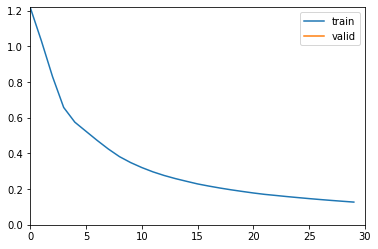

epoch,train_loss,valid_loss,foreground_acc,time
0,0.028978,0.048055,0.000000,00:29
1,0.023950,0.046401,0.000000,00:29
2,0.020896,0.029282,0.022513,00:29
3,0.017692,0.043072,0.033739,00:29
4,0.015405,0.028033,0.212603,00:29
5,0.014994,0.014404,0.469890,00:28
6,0.013368,0.016710,0.392413,00:29
7,0.012183,0.012349,0.480743,00:29
8,0.011984,0.022627,0.330380,00:27
9,0.010949,0.017990,0.316173,00:27


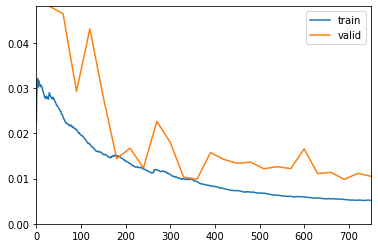

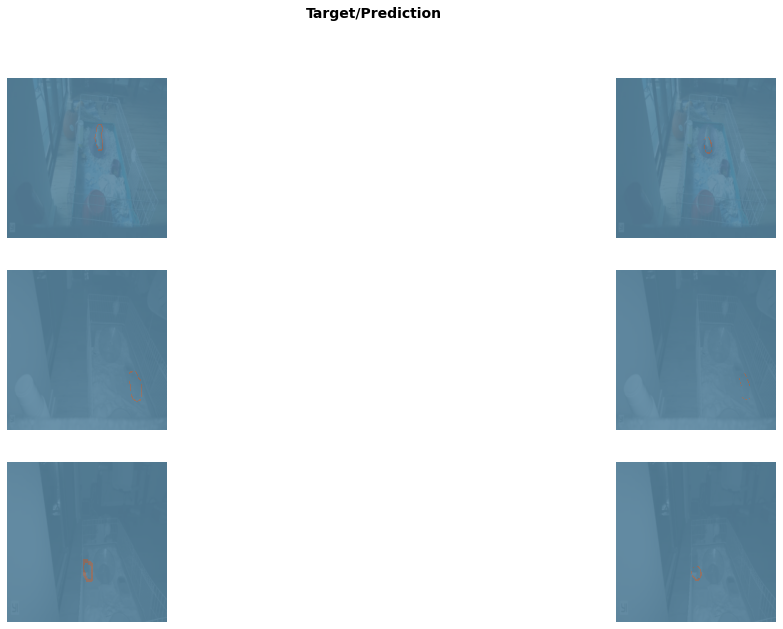

In [7]:
no_norm_learner = load_model(get_dls_no_norm(8, 224), 'no_norm')
no_norm_learner.fine_tune(25)
no_norm_learner.show_results(max_n=3, figsize=(20,10))

## Conclusions from the train-validation curves

The training curve above shows the model performance over time as measured by the loss, where lower values are better. The model performs well on the training data, these are the data the model actually learns from, but the validation results are poorer and more erratic. This suggests that what the model is learning is not generalizable to new data, that the model has only memorized what it has already seen without learning the underlying features.

This becomes more clear when we look at predictions on data the model has never seen before. We see that the model often completely misses Xiaomi!

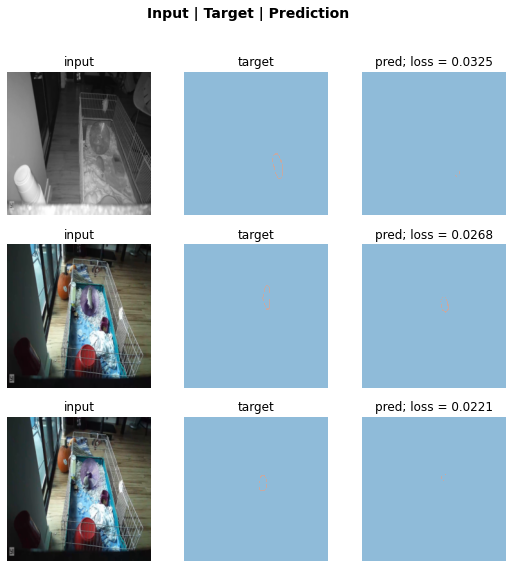

In [8]:
interp = SegmentationInterpretation.from_learner(no_norm_learner)
interp.plot_top_losses(k=3)

In [9]:
test_images = get_image_files(test_path / 'images')
print(len(test_images), 'test images')

13 test images


In [10]:
import matplotlib.pyplot as plt

from hedgiefinder import HedgieFinder
from hedgiefinder.inference import alpha_mask
from scipy.ndimage.interpolation import zoom

## Now add imagenet normalization

Much of the fastai book is concerned with avoiding overfitting, which is exactly the issue we are dealing with here. The model memorizes the training set, but doesn't perform well on new images, as shown above, the model completely misses Xiaomi! [Chapter 7 of Fastbook](https://github.com/fastai/fastbook/blob/master/07_sizing_and_tta.ipynb) introduces several powerful means to avoid overfitting. The first that we'll incorporate here is **normalization**. As the book states, normalization is especially important when using pretrained models (which we are using in our Hog Finder model! resnet34). Transfer learning with pretrained models is one of the only practical means to implement deep learning because you don't need lots of training data, you benefit from the previous training done by the original model trainers who have more resources, time, and expertise to pretrain excellent models. Transfer learning is a major theme of fastai and key to what makes deep learning accessible outside of the ivory towers of big corporations. With that in mind, normalization enables us to better utilize existing models by formatting our data to fall within the range of values that the pretrained model has already seen.

In [11]:
def get_dls_imagenet_norm(bs=8, size=224):
    hogvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                       get_items=get_image_files,
                       splitter=RandomSplitter(),
                       get_y=get_msk,
                       batch_tfms=[*aug_transforms(do_flip=False, max_rotate=2),  Normalize.from_stats(*imagenet_stats)],
                       item_tfms=Resize(size, method='squish'))

    return hogvid.dataloaders(path / 'images', path=path, bs=bs)


def get_dls_norm(bs=8, size=224):
    hogvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                       get_items=get_image_files,
                       splitter=RandomSplitter(),
                       get_y=get_msk,
                       batch_tfms=[*aug_transforms(do_flip=False, max_rotate=2),  Normalize],
                       item_tfms=Resize(size, method='squish'))

    return hogvid.dataloaders(path / 'images', path=path, bs=bs)

dls = get_dls_norm()

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,foreground_acc,time
0,0.100667,0.045382,0.000000,00:27


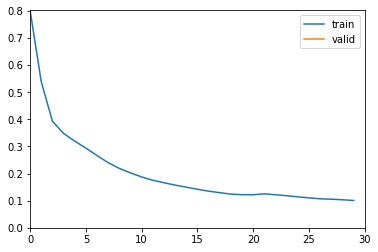

epoch,train_loss,valid_loss,foreground_acc,time
0,0.030872,0.022624,0.096961,00:29
1,0.024865,0.023626,0.240914,00:28
2,0.021224,0.016315,0.570721,00:28
3,0.018231,0.018550,0.543725,00:28
4,0.016029,0.013222,0.519391,00:28
5,0.013772,0.012412,0.523672,00:28
6,0.012136,0.010225,0.680479,00:28
7,0.010646,0.011297,0.669315,00:28
8,0.010232,0.009991,0.665649,00:28
9,0.009019,0.009667,0.693291,00:28


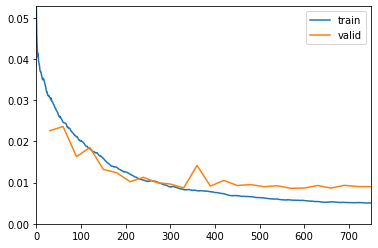

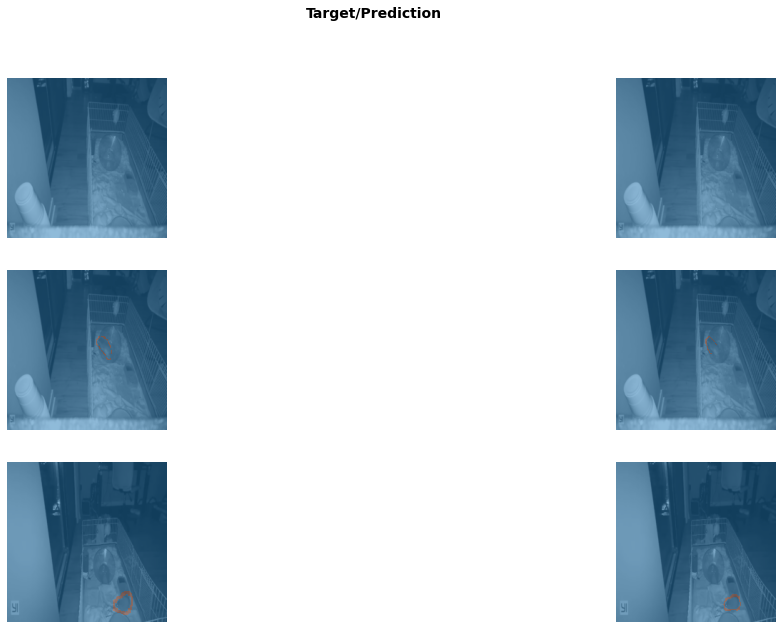

In [12]:
norm_learner = load_model(get_dls_norm(8, 224), 'norm')
norm_learner.fine_tune(25)
norm_learner.show_results(max_n=3, figsize=(20,10))

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,foreground_acc,time
0,0.248029,0.035544,0.000000,00:58


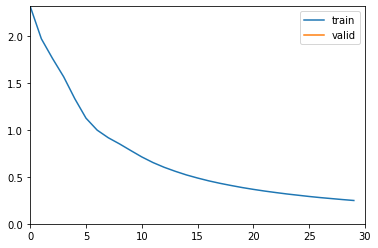

epoch,train_loss,valid_loss,foreground_acc,time
0,0.036892,0.030777,0.000000,01:51
1,0.030344,0.022092,0.000000,01:51
2,0.025219,0.017873,0.439045,01:54
3,0.020465,0.012920,0.557162,01:55
4,0.017544,0.013071,0.560946,01:52
5,0.014937,0.011928,0.557515,01:55
6,0.012679,0.011046,0.670125,01:50
7,0.024883,0.020071,0.000000,01:54
8,0.020621,0.015391,0.410568,01:58
9,0.016346,0.010128,0.626237,01:57


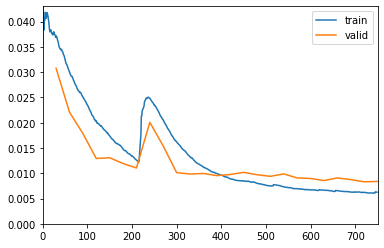

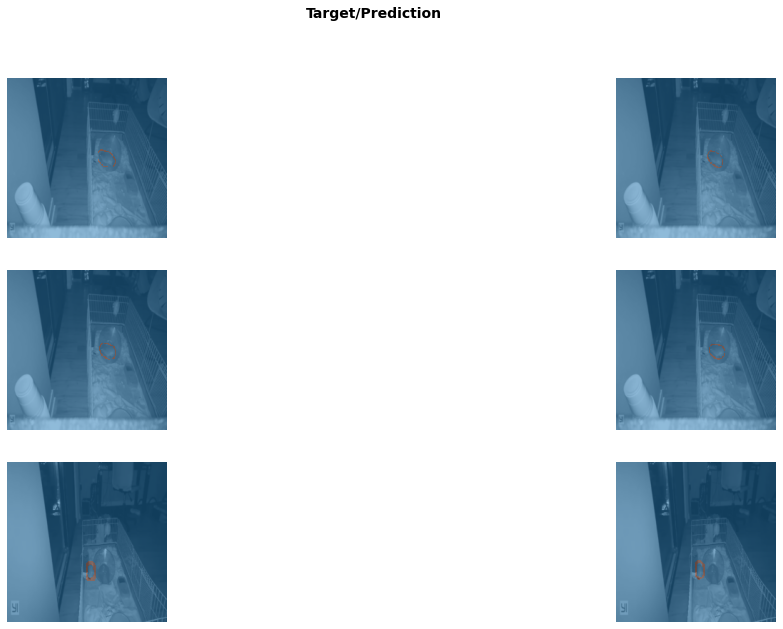

In [13]:
imagenet_norm_learner = load_model(get_dls_imagenet_norm(8, 224), 'norm')
imagenet_norm_learner.fine_tune(25)
imagenet_norm_learner.show_results(max_n=3, figsize=(20,10))

## The addition of ImageNet normalization made a huge difference!!

With the simple addition of ImageNet normalization, we see that the validation curve better follows the training loss curve, meaning that what the model is learning is generalizable to other data. In addition the model accuracy is 10-20 percentage points higher than before! 73% vs 53%!

We do start to see some overfitting potentially as the validation loss curve exceeds the train curve, however this is desirable to some degree as it means we are not under-fitting.

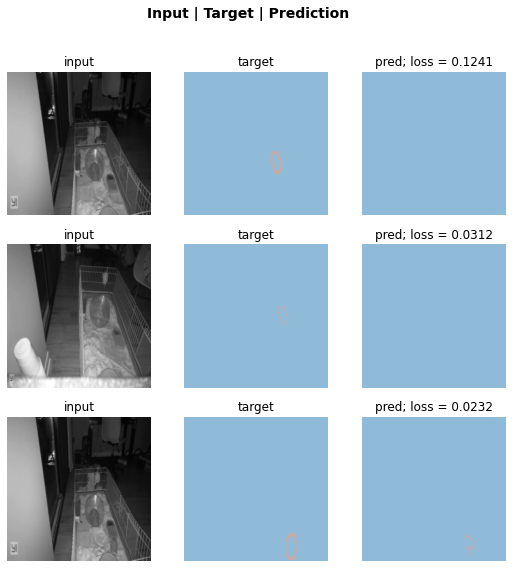

In [14]:
interp = SegmentationInterpretation.from_learner(norm_learner)
interp.plot_top_losses(k=3)

In [15]:
def show_overlay(learner, test_im, fname=None):
    original = plt.imread(test_im)
    pred_small = learner.predict(test_im)[0]
    pred = zoom(pred_small, np.array(original.shape[:-1])/np.array(pred_small.shape))
    overlay = alpha_mask(original, pred)

    f, axs = plt.subplots(1,1, figsize=(16,16))
    axs.imshow(overlay)
    if fname:
        plt.savefig(fname)
    plt.show()
    return overlay

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


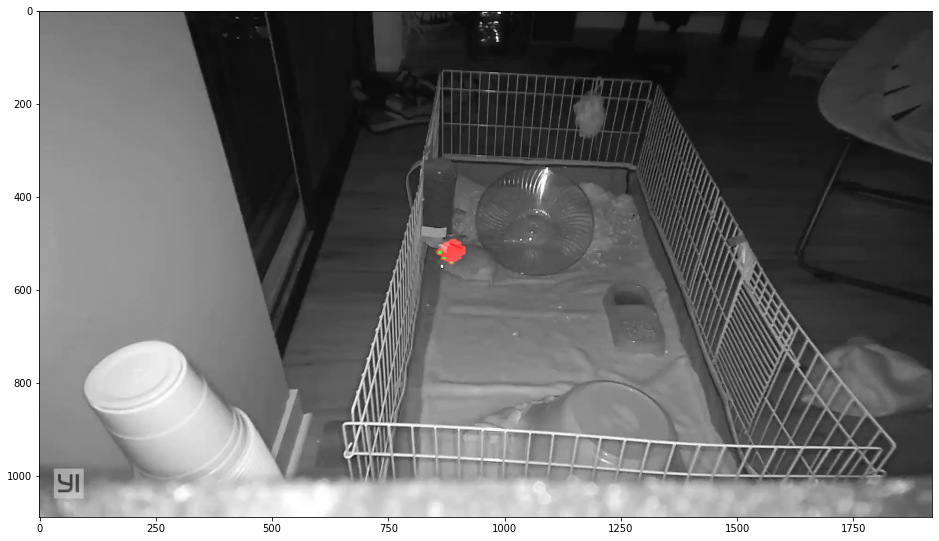

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


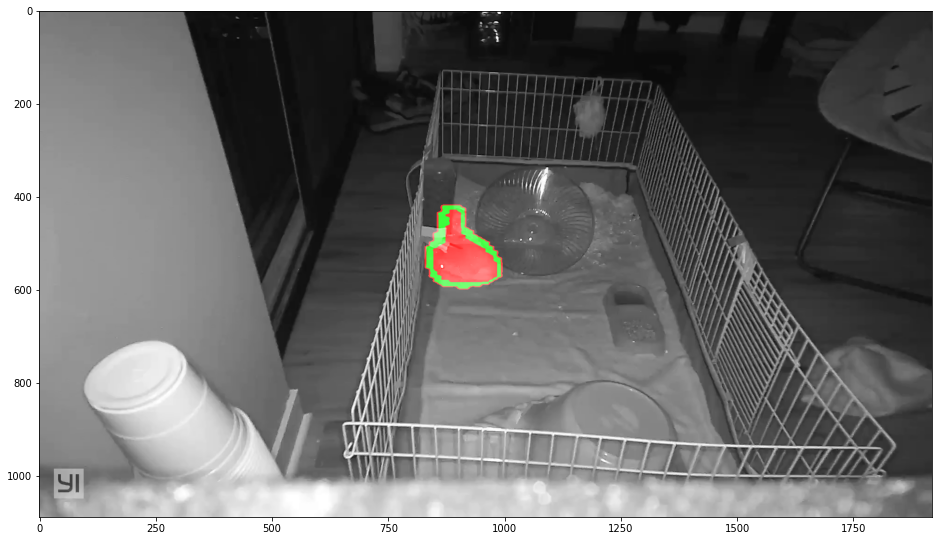

In [16]:
test_im = test_images[0]
no_norm_im = show_overlay(no_norm_learner, test_im, 'no_norm.png')
norm_im = show_overlay(norm_learner, test_im, 'norm.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


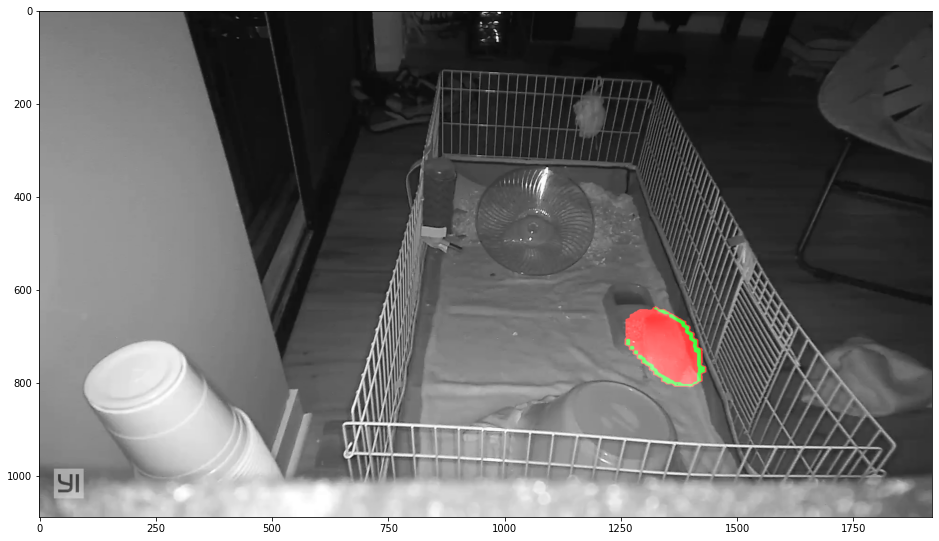

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


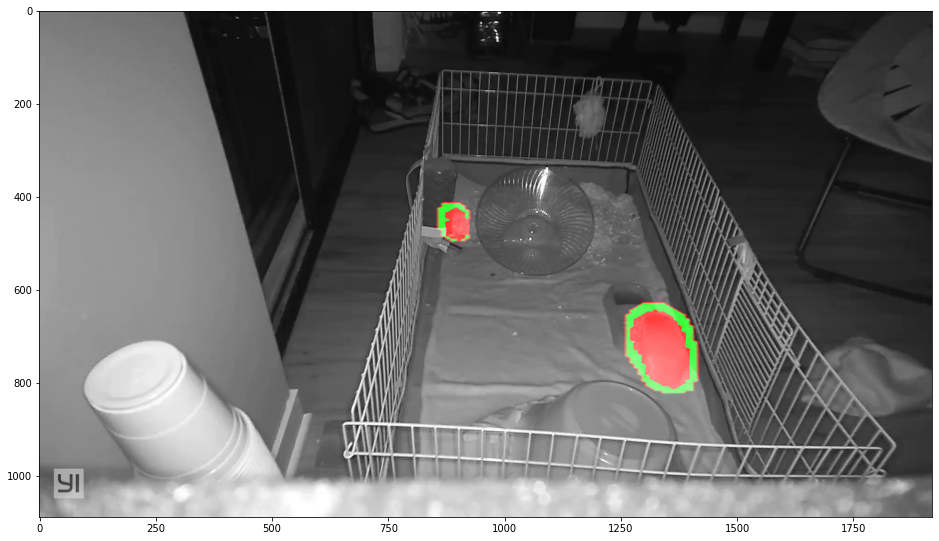

In [17]:
test_im = test_images[12]
no_norm_im = show_overlay(no_norm_learner, test_im, 'no_norm.png')
norm_im = show_overlay(norm_learner, test_im, 'norm.png')

It found her! But it's not perfect. Can we do better?

## How does the model generalize to other hedgehogs?

- instagram hogs...

### Explore Progressize resizing

In [18]:
import os
prog_hist_csv = Path('prog_history.csv') #base_path/'notebooks'/'prog_history.csv'
if prog_hist_csv.exists():
    os.remove(prog_hist_csv)

In [19]:
prog_learner = load_model(get_dls_norm(8, 224), 'prog', append=True)
prog_learner.fit_one_cycle(15)
prog_learner.dls = get_dls_norm(2, 360)
prog_learner.fine_tune(10)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,foreground_acc,time


RuntimeError: CUDA out of memory. Tried to allocate 152.00 MiB (GPU 0; 8.00 GiB total capacity; 4.79 GiB already allocated; 142.11 MiB free; 5.13 GiB reserved in total by PyTorch)

77% Accruracy! That's even better than with normalizaion alone. You can see that the progressive resizing model also does a better job of not having artifacts around the water bottle which was an issue with the `norm_learner`

In [ ]:
interp = SegmentationInterpretation.from_learner(prog_learner)
interp.plot_top_losses(k=3)

In [ ]:
prog_im = show_overlay(no_norm_learner, test_im)
prog_im = show_overlay(norm_learner, test_im)
prog_im = show_overlay(prog_learner, test_im)

## Export Models for Further Evaluation

In [ ]:
model_path = Path('test_models')
model_path.mkdir(exist_ok=True, parents=True)
model_path.absolute()

In [ ]:
no_norm_learner.path = base_path / 'notebooks' / 'model_exploration' / 'test_models'
no_norm_learner.remove_cb(CSVLogger)
no_norm_learner.export('no_norm_model.pkl')

norm_learner.path = base_path / 'notebooks' / 'model_exploration' / 'test_models'
norm_learner.remove_cb(CSVLogger)
norm_learner.export('norm_model.pkl')

prog_learner.path = base_path / 'notebooks' / 'model_exploration' / 'test_models'
prog_learner.remove_cb(CSVLogger)
prog_learner.export('prog_model.pkl')

## Other overfitting avoidance techniques to try:

- test time augmentation (tta)
- mixup
- label smoothing

In [ ]:
(base_path / 'hedgiefinder' / 'models').exists()

In [ ]:
save_model = True

top_model = norm_learner
# Add modelname

from datetime import datetime
model_path = base_path / 'hedgiefinder' / 'models'
model_name = model_path / "datetime.now().strftime("%Y%m%d_%H%M.pkl")

if save_model:
    model_dir = model_name.parent
    model_dir.mkdir(exist_ok=True)

    top_model.export(model_name)
    print(model_name)

## Conclusions

We've summarized here some of the very powerful techniques for managing overfitting documented in Fastbook and easily implemented in fastaiv2.
- Normalization was key for more predictable validation curves that better match the training loss, indicating better generalizability of the model
- Progressive resizing further improved the generalization of our model by adding further data augmentation which made our model more reliable against artifacts